# Google Play Store (Ratings)

Código baseado no trabalho apresentado na cadeira de Probabilidade e Processos Estocásticos  ([GooglePlayStats](https://github.com/JailsonLiberato/GooglePlayStats)).

Dataset utilizado: [Google Play Store Apps](https://www.kaggle.com/lava18/google-play-store-apps)

## Contexto

Exemplo de regressão linear utilizando o TensorFlow como forma de prever a avaliação (rating) de um aplicativo.

## Setup

Importando e carregando o dataset (via github)

In [8]:
from tensorflow.python.data import Dataset
from IPython import display
from sklearn import metrics
from matplotlib import pyplot as plt

import tensorflow as tf
import pandas as pd
import numpy as np

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

googleplaystore_dataframe = pd.read_csv("https://raw.githubusercontent.com/arthurflor/courses/master/google-machine-learning-crash-course/googleplaystore_pre_process.csv", sep=",")
googleplaystore_dataframe = googleplaystore_dataframe.reindex(np.random.permutation(googleplaystore_dataframe.index))

googleplaystore_dataframe

,app,category,rating,review,size,install,type,price,content_rating,genre,last_uptaded,current_ver,android_ver
2762,REI – Shop Outdoor Gear,SHOPPING,4.4,3878,8.8,100,0,0.0,Everyone,Shopping,"May 8, 2018",5.6.8,4.1
4401,Prime Key for Nougat Launcher& O Launcher &KitKat,PERSONALIZATION,4.1,324,313.0,5,1,7.0,Everyone,Personalization,"August 20, 2017",5.1,5.1
1340,"Zombies, Run! 5k Training (Free)",HEALTH_AND_FITNESS,4.0,267,0.0,50,0,0.0,Teen,Health & Fitness,"August 1, 2018",0.0,0.0
3908,Draw A Stickman,GAME,3.4,29265,17.0,1000000,0,0.0,Everyone,Adventure,"May 19, 2017",1.1.0,4.0.3
6402,BL Community Icon Pack,PERSONALIZATION,4.0,289,2.7,10,0,0.0,Everyone,Personalization,"May 6, 2013",1.01,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,Lose Weight in 30 Days,HEALTH_AND_FITNESS,4.8,220125,11.0,10000000,0,0.0,Everyone,Health & Fitness,"July 31, 2018",1.0.14,4.0
9199,EC MANAGER,VIDEO_PLAYERS,0.0,2,17.0,100,0,0.0,Everyone,Video Players & Editors,"June 13, 2018",8.3.13.6,4.1
166,Job Search by ZipRecruiter,BUSINESS,4.8,148945,25.0,1000000,0,0.0,Everyone,Business,"July 19, 2018",5.2.8,5.0
7651,CP Plus Showcase,BUSINESS,4.3,236,7.0,50,0,0.0,Everyone,Business,"March 9, 2018",1.0.4,4.0


## Pré-processamento dos dados

Funções para pré-processamento dos inputs e targets

In [0]:
def preprocess_features(googleplaystore_dataframe):
  """Preparar inputs do dataset googleplaystore.

  Args:
    googleplaystore_dataframe: Pandas DataFrame (dataset).

  Returns:
    DataFrame contendo os inputs necessários.
  """

  selected_features = googleplaystore_dataframe[[
      "category",
      "review",
      "size",
      "install",
      "type",
      "price",
      "content_rating",
      "genre",
      "android_ver",
   ]]

  processed_features = selected_features.copy()
  
  # Criando grupos (códigos) para as categorias
  processed_features["category"] = pd.Categorical(processed_features["category"]).codes
  processed_features["content_rating"] = pd.Categorical(processed_features["content_rating"]).codes
  processed_features["genre"] = pd.Categorical(processed_features["genre"]).codes
  processed_features["android_ver"] = pd.Categorical(processed_features["android_ver"]).codes
  
  # Criando atributo sintético.
  processed_features["install_sub_review"] = (googleplaystore_dataframe["install"] - googleplaystore_dataframe["review"])
    
  return processed_features

def preprocess_targets(googleplaystore_dataframe):
  """Preparar targets do dataset googleplaystore.

  Args:
    googleplaystore_dataframe: Pandas DataFrame (dataset).

  Returns:
    DataFrame contendo os targets.
  """
  
  output_targets = pd.DataFrame()
  
  # Criando valor booleano representando um "app de sucesso".
  norm_rating = (googleplaystore_dataframe["rating"] * (googleplaystore_dataframe["install"]/100))
  
  output_targets["app_success"] = (norm_rating > 4).astype(float)
    
  return output_targets

Carregamento dos dados, utilizando as funções de pré-processamento. Os dados são divididos em 80% para treinamento e 20% para validação

In [10]:
length = len(googleplaystore_dataframe)
training_len = int(length * 0.8)
validation_len = int(length * 0.2)

training_examples = preprocess_features(googleplaystore_dataframe.head(training_len))
training_targets = preprocess_targets(googleplaystore_dataframe.head(training_len))

validation_examples = preprocess_features(googleplaystore_dataframe.tail(validation_len))
validation_targets = preprocess_targets(googleplaystore_dataframe.tail(validation_len))

print("Resumo dos dados de treino (inputs):")
display.display(training_examples.describe())

print("Resumo dos dados de treino (targets):")
display.display(training_targets.describe())


print("Resumo dos dados de validação (inputs):")
display.display(validation_examples.describe())

print("Resumo dos dados de validação (targets):")
display.display(validation_targets.describe())

Resumo dos dados de treino (inputs):


,category,review,size,install,type,price,content_rating,genre,android_ver,install_sub_review
count,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0,8640.0
mean,16.8,457234.2,31.8,15374368.6,0.1,1.0,1.3,63.1,13.8,14917134.4
std,8.3,3029955.3,92.9,84681420.7,0.3,16.0,0.7,31.9,6.8,82710992.6
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-167474.0
25%,11.0,37.0,3.1,10.0,0.0,0.0,1.0,37.0,10.0,-142.0
50%,14.0,2167.0,10.0,100.0,0.0,0.0,1.0,66.0,15.0,88.0
75%,25.0,54800.2,29.0,5000000.0,0.0,0.0,1.0,94.0,17.0,4827492.0
max,32.0,78158306.0,1020.0,1000000000.0,1.0,400.0,3.0,113.0,32.0,999122365.0


Resumo dos dados de treino (targets):


,app_success
count,8640.0
mean,0.6
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


Resumo dos dados de validação (inputs):


,category,review,size,install,type,price,content_rating,genre,android_ver,install_sub_review
count,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0,2160.0
mean,16.7,399777.1,29.2,15883856.0,0.1,1.0,0.2,48.6,11.9,15484078.9
std,8.3,2508432.1,87.8,87204905.6,0.3,13.2,0.6,24.4,5.9,85790337.7
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-83614.0
25%,11.0,38.0,3.1,10.0,0.0,0.0,0.0,28.0,8.0,-154.2
50%,14.0,1906.5,10.0,100.0,0.0,0.0,0.0,51.0,13.0,49.5
75%,24.0,56417.8,28.0,5000000.0,0.0,0.0,0.0,66.0,15.0,4837288.0
max,32.0,66577313.0,982.0,1000000000.0,1.0,400.0,3.0,89.0,25.0,999122365.0


Resumo dos dados de validação (targets):


,app_success
count,2160.0
mean,0.6
std,0.5
min,0.0
25%,0.0
50%,1.0
75%,1.0
max,1.0


## Formatando input com Dataset

Função para formatar o input para o tensorflow, utilizando o estimator Dataset

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Organizar dados para treinamento.
  
    Args:
      features: pandas DataFrame (inputs)
      targets: pandas DataFrame (targets)
      batch_size: tamanho do batch para o treinamento
      shuffle: Embaralhar os dados.
      num_epochs: Número de épocas. None=indefinido
    
    Returns:
      Tupla de atributos e targets.
    """
    
    features = {index:np.array(item) for (index, item) in dict(features).items()}                                            
 
    ds = Dataset.from_tensor_slices((features, targets)) # limite de 2GB
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

## Treinamento sem estimator

Função de treinamento com plot de métricas e resultados

In [0]:
def train_without_estimator(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
  """Treinar modelo. Mostrar progresso de treinamento e resultados.
    
  Args:
    learning_rate: taxa de aprendizagem (float).
    steps: número de etapas do treinamento (int > 0). Consiste em uma passagem de "ida e volta" de um batch.
    batch_size: tamanho de um batch (int > 0).
    training_examples: Pandas DataFrame contendo uma ou mais colunas do dataset como atributos de input para o treinamento.
    training_targets: Pandas DataFrame contendo uma coluna com os targets (labels) para o treinamento.
    validation_examples: Pandas DataFrame contendo uma ou mais colunas do dataset como atributos de input para a validação.
    validation_targets: Pandas DataFrame contendo uma coluna com os targets (labels) para a validação.

  Returns:
    Objeto `LinearClassifier' treinado.
  """

  epochs = 10
  steps_per_epoch = steps/epochs
    
  # lambda para auxiliar na construção dos atributos categóricos
  construct_feature_columns = lambda input_features: set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])
  
  # otimizador
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  
  # classificador linear
  linear_classifier = tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
  
  # lambdas para a organização dos inputs
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["app_success"], num_epochs=1, shuffle=False)
  
  print("Treinando...")  
  training_log_losses = []
  validation_log_losses = []
  
  for epoch in range(0, epochs):
    # treinamento `training_input_fn`
    linear_classifier.train(input_fn=training_input_fn, steps=steps_per_epoch)
    
    # calcular previsões `predict_training_input_fn` (treinamento)
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    # calcular previsões `predict_validation_input_fn` (validação)
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # calculando log_loss do treinamento e validação
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    
    print("epoch %s | loss %0.4f | val_loss %0.4f" % ((epoch+1), training_log_loss, validation_log_loss))
    
    # adicionar as métricas desse período nas listas
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)

  print("Treinamento finalizado.\n")
  
  # calculando acurácia e plotando curva ROC dos dados de validação
  evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
  
  # calculando previsões `predict_validation_input_fn` (validação)
  validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
  
  # probabilidade (verdadeiro positivo e falso positivo)
  validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])
  false_positive_rate, true_positive_rate, _ = metrics.roc_curve(validation_targets, validation_probabilities)
  
  print("AUC dos dados de validação: %0.4f" % evaluation_metrics['auc'])
  print("Acurácia dos dados de validação: %0.4f\n" % evaluation_metrics['accuracy'])

  plt.figure(0)
  plt.title("AUC")
  plt.plot(false_positive_rate, true_positive_rate, label="our model")
  plt.plot([0, 1], [0, 1], label="random classifier")
  plt.legend()
  
  # plot de gráfico da métrica: log_loss vs períodos.
  plt.figure(1)
  plt.ylabel("LogLoss")
  plt.xlabel("Epochs")
  plt.title("LogLoss vs. Epochs")
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()
  
  return linear_classifier

Treinando...
epoch 1 | loss 0.3207 | val_loss 0.3268
epoch 2 | loss 0.2838 | val_loss 0.2908
epoch 3 | loss 0.2643 | val_loss 0.2692
epoch 4 | loss 0.2535 | val_loss 0.2579
epoch 5 | loss 0.2471 | val_loss 0.2491
epoch 6 | loss 0.2431 | val_loss 0.2445
epoch 7 | loss 0.2408 | val_loss 0.2399
epoch 8 | loss 0.2396 | val_loss 0.2401
epoch 9 | loss 0.2383 | val_loss 0.2365
epoch 10 | loss 0.2379 | val_loss 0.2384
Treinamento finalizado.

AUC dos dados de validação: 0.9686
Acurácia dos dados de validação: 0.9167



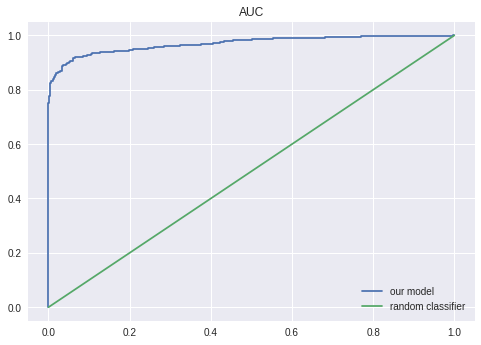

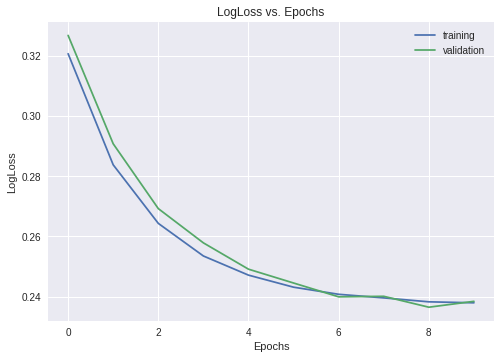

In [16]:
tf.logging.set_verbosity(tf.logging.ERROR)

linear_classifier = train_without_estimator(
    learning_rate=0.000003,
    steps=10000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Treinamento com estimator

Função de treinamento e plot de métricas e resultados, utilizando o estimator train_and_evaluate

In [0]:
def metric_fn(labels, predictions):
  return {'auc': tf.metrics.auc(labels, predictions['logistic'])}

def train_with_estimator(learning_rate, batch_size, training_examples, training_targets, validation_examples, validation_targets):

  # otimizador
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  
  # lambdas para a organização dos inputs
  training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["app_success"], num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["app_success"], num_epochs=1, shuffle=False)
    
  # classificador linear
  features_col = set([tf.feature_column.numeric_column(my_feature) for my_feature in training_examples])
  
  linear_classifier = tf.estimator.LinearClassifier(feature_columns=features_col, optimizer=my_optimizer)
  estimator = tf.contrib.estimator.add_metrics(linear_classifier, metric_fn)
  
  train_spec = tf.estimator.TrainSpec(input_fn=training_input_fn, max_steps=100)
  eval_spec = tf.estimator.EvalSpec(input_fn=predict_validation_input_fn, steps=None)
  
  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
  

In [20]:
tf.logging.set_verbosity(tf.logging.INFO)

linear_classifier = train_with_estimator(
    learning_rate=0.00003,
    batch_size=100,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_uhdp8qy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fadbff009e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_uhdp8qy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_step